In [1]:
import torch
print(torch.cuda.is_available())

True


In [5]:
pip install gym-super-mario-bros

  Using cached gym_super_mario_bros-7.4.0-py3-none-any.whl.metadata (10 kB)
Using cached gym_super_mario_bros-7.4.0-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install shimmy>=0.2.1

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym

env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)



C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [7]:
done = True
env.reset()
for step in range(5000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
       env.reset()

env.close()

C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

In [8]:
env.close()

Preprocessing the Environment (PPO algorithm)

In [10]:
pip install stable-baselines3

Note: you may need to restart the kernel to use updated packages.Collecting stable-baselines3
  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-win_amd64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached stable_baselines3-2.3.2-py3-none-any

In [2]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [3]:
#1. Create the base environment
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")

# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)

#3. GrayScale
env = GrayScaleObservation(env, keep_dim = True)

#4. Wrap inside the Dummy environment
env = DummyVecEnv([lambda: env])

#5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\vrajp\Coding\Mario RL Agent\MarioNew\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [4]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

In [5]:
state = env.reset()

In [14]:
state, reward, done, info = env.step([5])

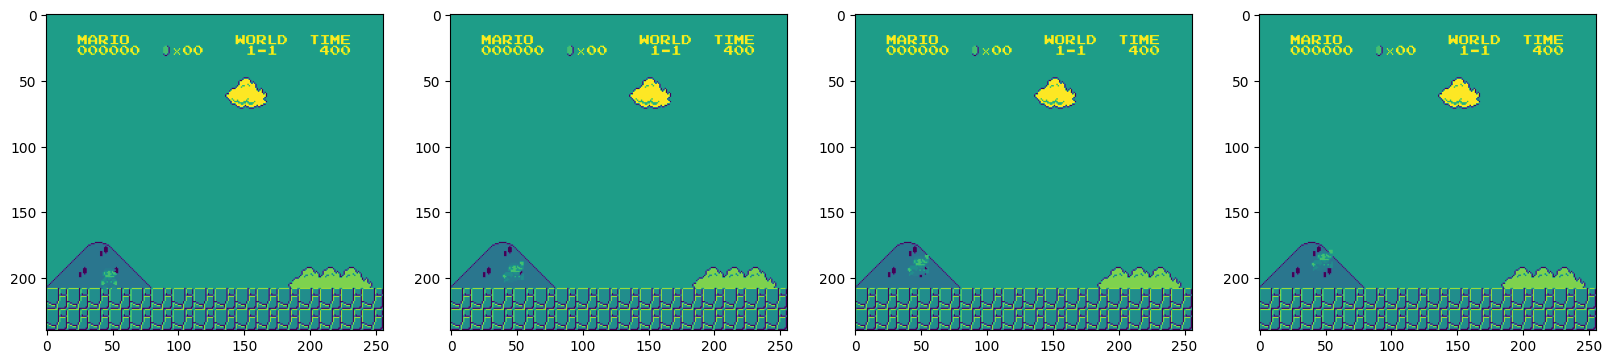

In [15]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Training the RL Model

In [16]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [17]:
#optional - allows to save model x number of steps, such taht the model isnt lost if it crashes
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [18]:
#setting directories
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [19]:
# Setup model saving callback (saves every 10000 steps)
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [20]:
import torch
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the PPO model, specifying the device
model = PPO('CnnPolicy', env, device=device, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [40]:
!pip install tensorboard

In [21]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to ./logs/PPO_4
----------------------------
| time/              |     |
|    fps             | 36  |
|    iterations      | 1   |
|    time_elapsed    | 14  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 2             |
|    time_elapsed         | 35            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 4.6535162e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.000504     |
|    learning_rate        | 1e-06         |
|    loss                 | 202           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00026      |
|    value_loss           | 518           |
-------------------------

Testing the Model out

In [41]:
# Load model
model = PPO.load('./train/best_model_900000')

In [42]:
state = env.reset()

In [43]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

KeyboardInterrupt: 

In [28]:
env.close()